In [16]:
import pandas as pd
import numpy as np
import math
import statsmodels.formula.api as sm
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
# Display Pipeline
from sklearn import set_config
set_config(display='diagram')


In [18]:
#FUNÇÃO PARA EXIBIS AS MÉTRICAS DO MODELO
def imprimir_metricas (y, y_pred, dataset_name='valid'):
  mean_y = np.mean(y)
  mean_pred = np.mean(y_pred)

  rmse = round(math.sqrt(mean_squared_error(y, y_pred)), 2)
  mae = mean_absolute_error(y, y_pred)
  r2 = r2_score(y, y_pred)
  mape = mean_absolute_percentage_error(y, y_pred)
  
  report = pd.DataFrame({
    'metric': ['RMSE', 'MAE', 'R^2', 'MAPE', 'Avg. target', 'Avg. Prediction'],
    dataset_name: [rmse, mae, r2, mape, mean_y, mean_pred]
  })

  report[dataset_name] = report[dataset_name].round(2)
  return report

<h2> 1. Lendo a base </h2>

In [19]:
df = pd.read_csv('Base_EMBRAESP_trabalhada.csv')
#df = df.drop(['MES_LAN', 'AGENTE', 'DATA_ENT', 'ZONA'], axis=1)

In [20]:
df.columns

Index(['Unnamed: 0.1', 'ID', 'TIPO_EMP', 'MES_LAN', 'ANO_LAN', 'DATA_ENT',
       'DIST', 'SUBPREF', 'MUNICIPIO', 'TIPO_VIA', 'ZONA', 'DORM_UNID',
       'BANH_UNID', 'GAR_UNID', 'ELEV', 'COB', 'BLOCOS', 'UNIDAND', 'ANDARES',
       'AR_UT_UNID', 'AR_TT_UNID', 'AR_TT_TERR', 'TT_UNID', 'DORM_EMP',
       'BANH_EMP', 'GAR_EMP', 'AU_EMP', 'AT_EMP', 'PC_TT_UN', 'PC_M2_AU',
       'PC_M2_AT', 'PC_TT_ATU', 'PC_AU_ATU', 'PC_AT_ATU', 'PC_EMP_ATU',
       'VLR_US__CO', 'PC_TT_UN_U', 'PC_M2_AU_U', 'PC_M2_AT_U', 'SIST_FINAN',
       'AGENTE', 'INCORPORAD', 'CONSTRUTOR', 'INCORPOR_A', 'CONSTRUT_A',
       'COOPERATIV', 'HOTEL', 'FLAT', 'EXFLAT', 'AP2010', 'SC_2010',
       'RENRESP91', 'RENRESP00', 'RENRESP10', 'PCMEDAU91', 'PCMEDAU00',
       'PCMEDAU10', 'BANH_DORM', 'Unnamed: 0', 'Domicílios_Setor',
       'Média_Moradores_por_domicilio_setor', 'Média_Renda_Responsaveis_Setor',
       'Domicilios no setor censitário', 'Domicilios alugados',
       'Domicilios unipessoais', 'Domicilios 2 ou 3 mo

In [21]:
df.columns
df = df.drop(['Unnamed: 0.1', 'Unnamed: 0','RENRESP91', 'PCMEDAU00',
       'PCMEDAU10', 'RENRESP00', 'ID', 'AGENTE', 'PC_TT_UN', 'PC_M2_AU', 'PC_M2_AT', 'PC_TT_ATU', 'PC_AT_ATU', 'PC_EMP_ATU',
       'VLR_US__CO', 'PC_TT_UN_U', 'PC_M2_AU_U', 'PC_M2_AT_U', 'PC_TT_UN_log', 'PC_M2_AT_log', 'VLR_US__CO_log', 'PCMEDAU10_log', 'PCMEDAU91', 'PC_M2_AU_log'], axis=1)

df['AR_UT_UNID_log'] = np.log(df['AR_UT_UNID'])
df['RENRESP10_log'] = np.log(df['RENRESP10'])

<h3>1.1 Definindo as variáveis que estarão presentes no modelo</h3>

In [22]:
target = 'PC_AU_ATU_log'
numericas = ['ANO_LAN', 'DORM_UNID', 'BANH_DORM', 'AR_UT_UNID']
categoricas = ['REGIAO', 'TIPO_EMP']
features = numericas + categoricas
#['', 'ANO_LAN', 'DORM_UNID', 'BANH_UNID', 'GAR_UNID']
v_ibge = ['Total de filhos dos responsáveis de domicílios', 'PERC_ALUGADOS',
       'PERC_UNIPESSOAIS', 'PERC_2_3_MORADORES', 'PERC_BRANCOS', 'PERC_PPI']

numericas2 = df.select_dtypes(['int', 'float']).columns
numericas2 = numericas2.drop(['PC_AU_ATU_log', 'PC_AU_ATU'])
categoricas2 = df.select_dtypes(['object', 'string']).columns


In [23]:
for col in categoricas2:
    df[col] = df[col].fillna(df[col].mode())

#df['REGIAO'] = df['REGIAO'].fillna(df['REGIAO'].mode())

In [24]:
df[categoricas2].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16935 entries, 0 to 16934
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   TIPO_EMP    16935 non-null  object
 1   MES_LAN     16935 non-null  object
 2   DATA_ENT    16935 non-null  object
 3   DIST        16935 non-null  object
 4   SUBPREF     16935 non-null  object
 5   MUNICIPIO   16935 non-null  object
 6   TIPO_VIA    16929 non-null  object
 7   ZONA        16935 non-null  object
 8   SIST_FINAN  16935 non-null  object
 9   INCORPORAD  16935 non-null  object
 10  CONSTRUTOR  16935 non-null  object
 11  INCORPOR_A  16935 non-null  object
 12  CONSTRUT_A  16935 non-null  object
 13  REGIAO      16804 non-null  object
dtypes: object(14)
memory usage: 1.8+ MB


<h2>2. Fazendo os modelos de regressão </h2>

In [25]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(target, axis=1), df[target], test_size=0.2)

<h3>2.1 Modelo de regressão linear </h3>
O modelo de regressão linear permite maior interpretabilidade das variáveis e da constituição do preço dos empreendimentos lançados. Contém alguma perda de performance em relação aos modelos mais avançados, como ensembles de Random Forest, mas são mais facilmente lidos.

<h3>2.1.1 - Criando o baseline</h3>
<>No modelo baseline foram consideradas variáveis que são intuitivamente conhecidas na descrição de um empreendimento imobiliário, como o número de dormitórios, o número de banheiros e a área do apartamento. <>

In [26]:
rl_baseline = sm.ols(formula='PC_AU_ATU ~ DORM_UNID + BANH_UNID + AR_UT_UNID', data=df.iloc[X_train.index,:]).fit()
rl_baseline_log = sm.ols(formula='PC_AU_ATU_log ~ DORM_UNID + BANH_UNID + AR_UT_UNID', data=df.iloc[X_train.index,:]).fit()

rl_baseline.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              PC_AU_ATU   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     861.4
Date:                Fri, 17 Mar 2023   Prob (F-statistic):               0.00
Time:                        21:11:31   Log-Likelihood:            -1.2621e+05
No. Observations:               13548   AIC:                         2.524e+05
Df Residuals:                   13544   BIC:                         2.525e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6100.5209     79.401     76.832      0.000    5944.884    6256.158
DORM_UNID  -1654.7056     45.141    -36.656      0.000   -1743.188   -1566.223
BANH_UNID   1143.9534     56.138     20.377      0.000    1033.915    1253.992
AR_UT_UNID    17.8855      0.811     22.051      0.000      16.296      19.475
==============================================================================
Omnibus:                     6155.763   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            54033.352
Skew:                           1.975   Prob(JB):                         0.00
Kurtosis:                      11.951   Cond. No.                         426.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Percebe-se que as variáveis relacionadas apenas ao apartamento não explicam bem, sozinhas, a variação do preço da área útil. O grau de explicabilidade das variáveis se mantém abaixo dos 20% para o caso da variável resposta em forma absoluta e logarítimica. 

O estudo sobre a dinâmica imobiliária no mercado de São Paulo leva ao entendimento de que duas variáveis são cruciais para o entendimento do preço das unidades: O local do empreendimento e o ano de lançamento. O local do empreendimento importa porque uma cidade desigual como São Paulo contém uma alta variabilidade no preço da terra, que se reflete diretamente nos valores de compra e venda de aluguéis dos imóveis; o ano de lançamento mantém relações com a macroeconomia, no sentido de que embora a demanda por moradia sempre seja alta, em anos de boom econômico a oferta e a disponibilidade de renda crescem exponencialmente. 
A seguir, essas duas variáveis são inseridas no modelo da resposta logarítimica do preço da área útil da unidade. 

In [27]:
regressao_au_log = sm.ols(formula='PC_AU_ATU_log ~ REGIAO + ANO_LAN + DORM_UNID + BANH_UNID + AR_UT_UNID', data=df.iloc[X_train.index,:]).fit()
regressao_au_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          PC_AU_ATU_log   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     701.4
Date:                Fri, 17 Mar 2023   Prob (F-statistic):               0.00
Time:                        21:11:31   Log-Likelihood:                -5417.8
No. Observations:               13439   AIC:                         1.086e+04
Df Residuals:                   13425   BIC:                         1.097e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               19.3022      0.801     24.098      0.000      17.732      20.872
REGIAO[T.Centro-Sul]    -0.0053      0.017     -0.320      0.749      -0.038       0.027
REGIAO[T.Leste 1]       -0.5466      0.020    -28.007      0.000      -0.585      -0.508
REGIAO[T.Leste 2]       -0.6851      0.033    -20.852      0.000      -0.749      -0.621
REGIAO[T.Nordeste]      -0.2928      0.019    -15.725      0.000      -0.329      -0.256
REGIAO[T.Noroeste]      -0.5288      0.031    -17.253      0.000      -0.589      -0.469
REGIAO[T.Oeste]         -0.0017      0.016     -0.104      0.917      -0.034       0.030
REGIAO[T.RMSP]          -0.5074      0.016    -31.196      0.000      -0.539      -0.476
REGIAO[T.Sudeste]       -0.2736      0.017    -16.065      0.000      -0.307      -0.240
REGIAO[T.Sul]           -0.3061      0.019    -15.940      0.000      -0.344      -0.268
ANO_LAN                 -0.0053      0.000    -13.147      0.000      -0.006      -0.004
DORM_UNID               -0.1769      0.006    -28.189      0.000      -0.189      -0.165
BANH_UNID                0.2157      0.008     27.341      0.000       0.200       0.231
AR_UT_UNID               0.0006      0.000      4.966      0.000       0.000       0.001
==============================================================================
Omnibus:                      117.605   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              163.276
Skew:                           0.114   Prob(JB):                     3.51e-36
Kurtosis:                       3.489   Cond. No.                     5.14e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.14e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

ESCREVER

In [56]:
regressao_au_log = sm.ols(formula='PC_AU_ATU_log ~ REGIAO + DORM_UNID + BANH_DORM + AR_UT_UNID + TIPO_EMP + RENRESP10 + INCORPORAD', data=df.iloc[X_train.index,:]).fit()
regressao_au_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          PC_AU_ATU_log   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     643.9
Date:                Fri, 17 Mar 2023   Prob (F-statistic):               0.00
Time:                        21:22:37   Log-Likelihood:                -3602.2
No. Observations:               13439   AIC:                             7256.
Df Residuals:                   13413   BIC:                             7452.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       7.9403      0.040    199.733      0.000       7.862       8.018
REGIAO[T.Centro-Sul]           -0.0936      0.015     -6.280      0.000      -0.123      -0.064
REGIAO[T.Leste 1]              -0.1878      0.018    -10.410      0.000      -0.223      -0.152
REGIAO[T.Leste 2]              -0.2984      0.030    -10.110      0.000      -0.356      -0.241
REGIAO[T.Nordeste]             -0.1074      0.017     -6.481      0.000      -0.140      -0.075
REGIAO[T.Noroeste]             -0.2252      0.027     -8.217      0.000      -0.279      -0.171
REGIAO[T.Oeste]                -0.0938      0.015     -6.417      0.000      -0.122      -0.065
REGIAO[T.RMSP]                 -0.3129      0.015    -21.371      0.000      -0.342      -0.284
REGIAO[T.Sudeste]              -0.1325      0.015     -8.771      0.000      -0.162      -0.103
REGIAO[T.Sul]                  -0.2766      0.017    -16.326      0.000      -0.310      -0.243
TIPO_EMP[T.VERTIC]              0.3033      0.009     33.110      0.000       0.285       0.321
INCORPORAD[T.ENCOL]             0.1532      0.045      3.393      0.001       0.065       0.242
INCORPORAD[T.EVEN]              0.0108      0.040      0.273      0.785      -0.067       0.089
INCORPORAD[T.GAFISA]           -0.0098      0.037     -0.263      0.793      -0.083       0.063
INCORPORAD[T.GOLDFARB]         -0.2379      0.040     -5.949      0.000      -0.316      -0.160
INCORPORAD[T.MRV]              -0.4024      0.041     -9.721      0.000      -0.484      -0.321
INCORPORAD[T.NAO INFORMADA]    -0.1225      0.037     -3.302      0.001      -0.195      -0.050
INCORPORAD[T.OUTRA]            -0.0824      0.033     -2.520      0.012      -0.147      -0.018
INCORPORAD[T.PLANO MELHOR]     -0.1748      0.048     -3.629      0.000      -0.269      -0.080
INCORPORAD[T.ROSSI]            -0.1042      0.040     -2.606      0.009      -0.183      -0.026
INCORPORAD[T.TECNISA]          -0.0572      0.039     -1.479      0.139      -0.133       0.019
INCORPORAD[T.TENDA]            -0.3552      0.045     -7.962      0.000      -0.443      -0.268
DORM_UNID                      -0.0311      0.006     -5.369      0.000      -0.042      -0.020
BANH_DORM                       0.3805      0.016     23.295      0.000       0.348       0.413
AR_UT_UNID                      0.0007   9.52e-05      7.160      0.000       0.000       0.001
RENRESP10                    8.876e-05   2.31e-06     38.443      0.000    8.42e-05    9.33e-05
==============================================================================
Omnibus:                      182.487   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              256.849
Skew:                           0.172   Prob(JB):             

<>3 - Modelo Random Forest<>

In [29]:
num_pipeline = Pipeline(steps=[
    ("input", SimpleImputer()),
    ('scaler', StandardScaler()),
    ])

In [30]:
cat_pipeline = Pipeline(steps=[
    ("cat", OneHotEncoder(handle_unknown= 'ignore'))
    ])

In [31]:
#TRANSFORMANDO COLUNAS
preprocessing = ColumnTransformer(transformers=[
    ('preprocessamento numerico', num_pipeline, numericas2),
    ('preprocessamento categorico', cat_pipeline, categoricas2)
])

In [32]:
model = Pipeline(steps=[('Preprocessamento', preprocessing),
                        ('regressao', RandomForestRegressor(n_estimators=10, max_features=0.3))])

In [33]:
model.fit(X_train, y_train)

Pipeline(steps=[('Preprocessamento',
                 ColumnTransformer(transformers=[('preprocessamento numerico',
                                                  Pipeline(steps=[('input',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['ANO_LAN', 'DORM_UNID', 'BANH_UNID', 'GAR_UNID', 'ELEV', 'COB',
       'BLOCOS', 'UNIDAND', 'ANDARES', 'AR_UT_UNID', 'AR_TT_UNID',
       'AR_TT_TERR', 'TT_UNID', 'DORM_EMP', 'BANH_EMP', 'GAR_EMP', 'AU_EMP...
      dtype='object')),
                                                 ('preprocessamento categorico',
                                                  Pipeline(steps=[('cat',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['TIPO_EMP', 'MES_LAN', 'DATA_ENT', 'DIST', 'SUBPREF', 'MUNICIPIO',
       'TIPO_VIA', 'ZONA', 'SIST_FINAN', 'INCORPORAD', 'CONSTRUTOR',
       'INCORPOR_A', 'CONSTRUT_A', 'REGIAO'],
      dtype='object'))])),
                ('regressao',
                 RandomForestRegressor(max_features=0.3, n_estimators=10))])

In [34]:
model.score(X_test, y_test)

0.8223095450504386

In [35]:
feature_importances = model[1][1].feature_importances_

In [36]:
permutation_result = permutation_importance(model, X_test, y_test, n_repeats=30)

In [37]:
df_importancia = pd.DataFrame({'column' : X_test.columns, 'importance': permutation_result.importances_mean})
df_importancia.sort_values(by='importance', ascending=False, inplace=True)

Text(0.5, 0.98, 'Variáveis mais importantes no entendimento dos valores de residências vendidas')

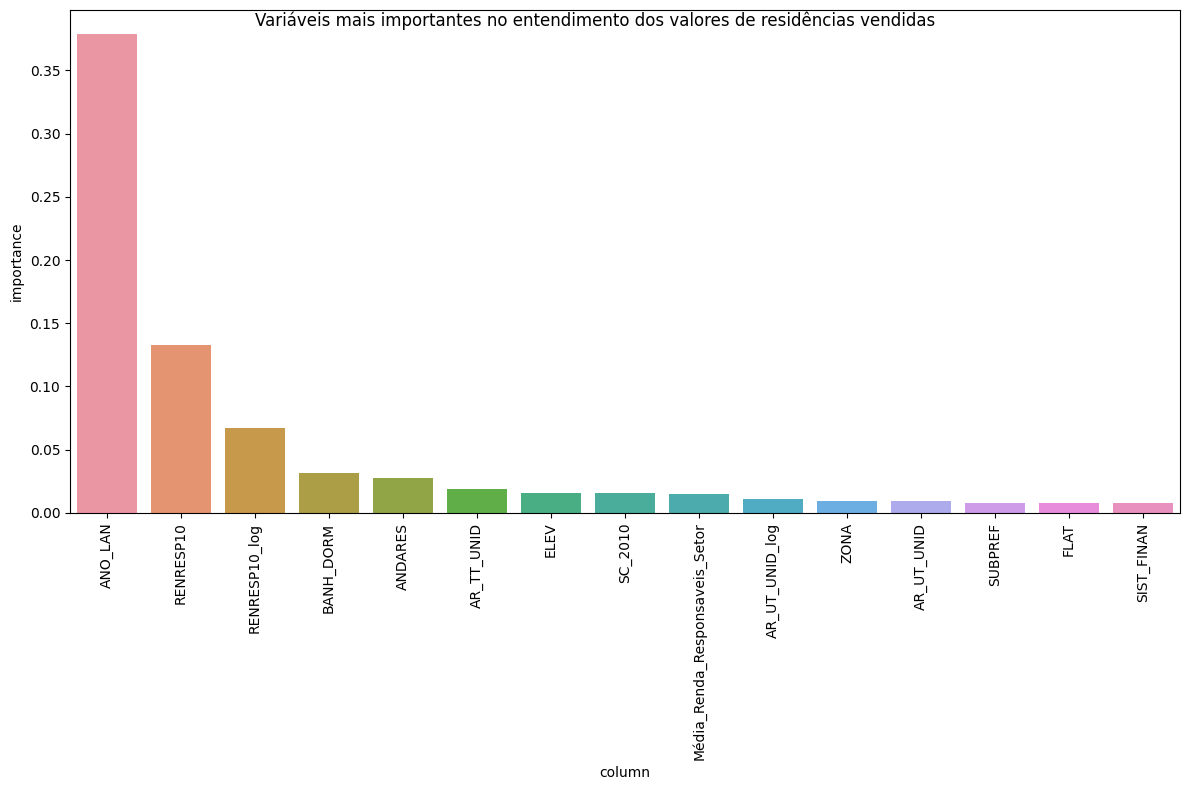

In [38]:
fig, axs = plt.subplots(figsize=(12,8), facecolor='white')
ax = sns.barplot(x='column', y="importance", data=df_importancia.nlargest(15, 'importance'))
plt.xticks(rotation=90)
plt.tight_layout()

fig.suptitle('Variáveis mais importantes no entendimento dos valores de residências vendidas')

Conjunto 1: 0.65 (RandomF), 0.39 (RegressãoL)
Conjunto IBGE: 0.53 (RandomF), 0.26 (RegressãoL)
Conjunto 1_log: 0.69 (RandomF), 0.40 (RegressãoL)

In [39]:
y_pred = model.predict(X_test)

In [40]:
baseline_report = imprimir_metricas(y_test, y_pred)
baseline_report

,metric,valid
0,RMSE,0.20
1,MAE,0.14
2,R^2,0.82
3,MAPE,0.02
4,Avg. target,8.53
5,Avg. Prediction,8.53
